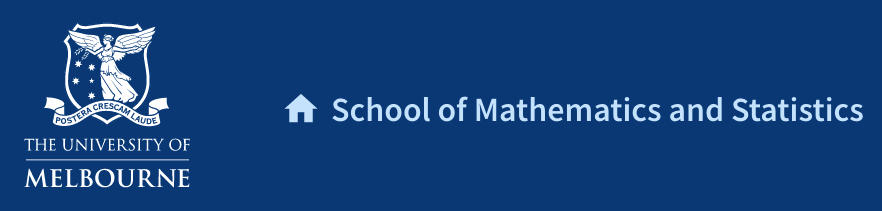

# MAST 90014 - Assignment 1

### Name: Simin Zuo
### Student Id: 1199404

Name your file as: yourstudentID.ipynb

## Main Problem description

Each month, ChemiCo produces insecticides for ants, spiders, cockroaches and moths. Products are manufactured at ChemiCo’s blending plants, stored at wharehouses and from there sent to the final distributors. The list of insectcides, plants, warehouses and distributors are shown below.



In [1]:
I = ["IAnt","ISpi","IRoa","IMot"]
P = ["PRic", "PBul", "PBwu"]
W = ["WPar", "WSou", "WWat", "WOrm"]
D = ['DDun', 'DVma', 'DRic', 'DIge', 'DKol', 'DAcc']

The production capacities and setup costs (cost that you must pay if the plant is used in the month) is presented in the file 'Chemico-plants.csv'. 

The orders made by each distributor for the month are presented in file 'orders.csv' (in thousand of litres) and the transportation cost per litre of insectcide is presented in file 'Chemico-transcosts.csv'.


## Question 1.

Model and implement a production/transportation problem to produce insectcides and transport them to the distributors while minimising plants setup and transportation costs. Warehouses WPar and WSou have a capacity of 30,000l each while WWat and WOrm have capacity of 35,000l each.

Variables:

* $x_{pi}:$ amount of Insecticide $i$ that Plant $p$ produced, 
* $\beta_{p}:$ binary variable, equal to $1$ Plant $p$ is used in this month; $0$ otherwise,
* $y_{ipw}:$ amount of Insecticide $i$ that Plant $p$ produced is stored in Warehouse $w$,
* $t_{iwd}:$ amount of Insecticide $i$ that Distributor $d$ needs is provided by Warehouse $w$.


Minimize:
$$
\sum_{p \in P} \beta_{p} \cdot f_{p} + \sum_{p \in P} \sum_{w \in W} \sum_{i \in I} y_{ipw} \cdot c_{pw} + \sum_{i \in I} \sum_{d \in D} \sum_{w \in W} t_{iwD} \cdot c_{wd}
$$
Subject to:
$$
\begin{aligned}
&\sum_{i \in I} x_{pi} \leq \beta_{p}*plantCap_{p}, \quad \forall p \in P \\
&\sum_{p \in P} x_{pi} = totalDemand_{i}, \quad \forall i \in I \\
&\sum_{i \in I} \sum_{p \in P} y_{ipw} \leq warehouseCap_{w}, \quad \forall w \in W \\
&\sum_{w \in W} y_{ipw} = \beta_{p}* x_{ip}, \quad \forall i \in I \quad \forall p \in P \\
&\sum_{d \in D} t_{iwd} = \sum_{p \in P} y_{ipw}, \quad \forall i \in I \quad \forall w \in W \\
&\sum_{w \in W} t_{iwd} = o_{id}, \quad \forall d \in D, \quad \forall i \in I \\
&\beta_{p} \in\{0,1\} \quad \forall p \in P \\
&x_{pi} \geq 0, \qquad \forall p \in P, \qquad \forall i \in I \\
&y_{ipw} \geq 0, \qquad \forall i \in I, \qquad \forall p \in P, \qquad \forall w \in W \\
&t_{iwd} \geq 0, \qquad \forall i \in I, \qquad \forall w \in W, \qquad \forall d \in D \\
\end{aligned}
$$

Meaning of constraints:
* amount of production for each plant should not exceed its production capacity 
* amount of porduced products should be enough to satisfy clients' demand
* amount of products stored in each warehouse should not exceed its storage capacity
* amount of each type of insecticide of each plant that sent to warehouses not exceed each plant's total producing amount
* amount of prodcts of wach plant that sent to warehouses should not exceed the amount of production
* amoutn of each product that sent to distributor is larger than or equal to the amount of their orders

In [2]:
# Write your code here
#import pacakges
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
# Read data
plants = open("Chemico-plants.csv", 'r').readlines()
orders = open("Chemico-orders.csv", 'r').readlines()
trans_costs = open("Chemico-transcosts.csv", 'r').readlines()


def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False


def read_lines(var):
    for i in range(len(var)):
        var[i] = var[i].strip().split(',')
        for j in range(len(var[i])):
            if is_number(var[i][j]):
                var[i][j] = float(var[i][j])
            elif var[i][j] == '':
                var[i][j] = 0
    return 


def list_to_dict(a_list):
    result = {}
    for i in range(1, len(a_list[0])):
        sub_dic = {}
        for j  in range(1, len(a_list)):
             sub_dic[a_list[j][0]] = a_list[j][i]
        result[a_list[0][i]] = sub_dic
    return result
      

read_lines(plants)
read_lines(orders)
read_lines(trans_costs)


# Data
Plant, plantCap, F = gp.multidict({
    'PRic': [70000.0, 1000000.0],
    'PBul': [30000.0, 750000.0],
    'PBwu': [50000.0, 800000.0]
})

warehouseCap = {"WPar": 30000, 
                "WSou": 30000, 
                "WWat": 35000, 
                "WOrm": 35000}
orders = list_to_dict(orders)
trans_costs = list_to_dict(trans_costs)
demand_summation = {}
for i in I:
    demand = 0
    for distributor in orders.keys():
        demand += orders[distributor][i]
    demand_summation[i] = demand * 1000


In [3]:
#MODEL:
m = gp.Model('Q1')

#variables
x = m.addVars(P, I, vtype = GRB.INTEGER, name="x")
beta = m.addVars(P, vtype = GRB.BINARY, name="beta")
y = m.addVars(I, P, W, vtype = GRB.INTEGER, name="y")
t = m.addVars(I, W, D, vtype = GRB.INTEGER, name="t")


#constraints
# 1.
m.addConstrs(gp.quicksum(x[p,i] for i in I) <= beta[p]*plantCap[p] for p in P)
# 2.
m.addConstrs(gp.quicksum(x[p,i] for p in P) == demand_summation[i] for i in I)
# 3.
m.addConstrs(gp.quicksum(y[i,p,w] for i in I for p in P) <= warehouseCap[w] for w in W)   
# 4.
m.addConstrs(gp.quicksum(y[i,p,w] for w in W) == beta[p]*x[p,i] for p in P for i in I) 
# 5.
m.addConstrs(gp.quicksum(t[i,w,d] for d in D) == gp.quicksum(y[i,p,w] for p in P) for w in W for i in I)
# 6.
m.addConstrs(gp.quicksum(t[i,w,d] for w in W) == orders[d][i]*1000 for d in D for i in I)


#objective
m.setObjective(gp.quicksum(beta[p]*F[p] for p in P) +
               gp.quicksum(y[i,p,w]*trans_costs[w][p] for i in I for p in P for w in W) +
               gp.quicksum(t[i,w,d]*trans_costs[d][w] for i in I for w in W for d in D), GRB.MINIMIZE)


#solve and display
m.optimize()          

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-29
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 51 rows, 159 columns and 315 nonzeros
Model fingerprint: 0xed59e6f9
Model has 12 quadratic constraints
Variable types: 0 continuous, 159 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 4e+04]
Presolve time: 0.06s
Presolved: 99 rows, 171 columns, 459 nonzeros
Variable types: 0 continuous, 171 integer (3 binary)
Found heuristic solution: objective 9638500.0000

Root relaxation: objective 6.809571e+06, 107 iterations, 0.04 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

In [4]:
print('Total cost: ', m.objVal)

total_setup_cost = 0
for p in P:
    total_setup_cost += beta[p].x*F[p]
print("Total setup Cost:",total_setup_cost)

trans_cost_PW = 0
for i in I:
    for p in P:
        for w in W:
            trans_cost_PW += y[i,p,w].x*trans_costs[w][p]
print("Total cost for transporting from plants to warehouses:", trans_cost_PW)

trans_cost_WD = 0    
for i in I:
    for d in D:
        for w in W:
            trans_cost_WD += t[i,w,d].x*trans_costs[d][w]
print("Total cost for transporting from warehouses to distributors:", trans_cost_WD)

print("Total production at each plant:")
plant_production = []
plant =[]
for p in P:
    production = 0
    for i in I:
        production += x[p,i].x
    plant.append(p)
    plant_production.append(round(production))
df=pd.DataFrame([pd.Series(plant_production, name="Total production", index=plant)])
print(df)

Total cost:  7141000.0
Total setup Cost: 1800000.0
Total cost for transporting from plants to warehouses: 3087000.0
Total cost for transporting from warehouses to distributors: 2254000.0
Total production at each plant:
                   PRic  PBul   PBwu
Total production  67000     0  50000


Present your code results here, including: 

* Total setup Cost - $1800000$
* Total cost for transporting from plants to warehouses - $3087000$
* Total cost for transporting from warehouses to distributors - $2254000$
* Table indicating the total production at each plant
* Total production at each plant:
                             PRic  PBul   PBwu
        Total production  67000     0  50000

## Question 2

To ensure the most stringent quality is met for all products, no two different insecticides can share the same warehouse. Model and implement this new production/transportation cost.

Variables:

* $x_{pi}:$ amount of Insecticide $i$ that Plant $p$ produced, 
* $\beta_{p}:$ binary variable, equal to $1$ Plant $p$ is used in this month; $0$ otherwise,
* $\alpha_{iw}:$ binary variable, equal to $1$ Plant $p$ produce insecticide $i$; $0$ otherwise,
* $y_{ipw}:$ amount of Insecticide $i$ that Plant $p$ produced is stored in Warehouse $w$,
* $t_{iwd}:$ amount of Insecticide $i$ that Distributor $d$ needs is provided by Warehouse $w$.

Minimize:
$$
\sum_{p \in P} \beta_{p} \cdot f_{p} + \sum_{p \in P} \sum_{w \in W} \sum_{i \in I} y_{ipw} \cdot c_{pw} + \sum_{i \in I} \sum_{d \in D} \sum_{w \in W} t_{iwD} \cdot c_{wd}
$$
Subject to:
$$
\begin{aligned}
&\sum_{i \in I} x_{pi}*\beta_{p} \leq plantCap_{p}, \quad \forall p \in P \\
&\sum_{p \in P} x_{pi}*\beta_{p} \geq totalDemand_{i}, \quad \forall i \in I \\
&\sum_{i \in I} \sum_{p \in P} y_{ipw}*\alpha_{iw} \leq warehouseCap_{w}, \quad \forall w \in W \\
&\sum_{w \in W} y_{ipw}*\alpha_{iw} \leq x_{ip}*\beta_{p}, \quad \forall i \in I \quad \forall p \in P \\
&\sum_{w \in W} y_{ipw}*\alpha_{iw} \leq x_{ip}*\beta_{p}, \quad \forall i \in I \quad \forall p \in P \\
&\sum_{w \in W} t_{iwd} \geq o_{id}, \quad \forall d \in D, \quad \forall i \in I \\
&\sum_{i \in I} \alpha_{iw} = 1, \quad \forall w \in W \\
&\beta_{p} \in\{0,1\} \quad \forall p \in P \\
&\alpha_{iw} \in\{0,1\} \quad \forall p \in P \\
&x_{pi} \geq 0, \qquad \forall p \in P, \qquad \forall i \in I \\
&y_{ipw} \geq 0, \qquad \forall i \in I, \qquad \forall p \in P, \qquad \forall w \in W \\
&t_{iwd} \geq 0, \qquad \forall i \in I, \qquad \forall w \in W, \qquad \forall d \in D
\end{aligned}
$$

Meaning of constraints:
* amount of production for each plant should not exceed its production capacity 
* amount of porduced products should be enough to satisfy clients' demand
* amount of products stored in each warehouse should not exceed its storage capacity
* amount of each type of insecticide of each plant that sent to warehouses not exceed each plant's total producing amount
* amount of prodcts of wach plant that sent to warehouses should not exceed the amount of production
* amoutn of each product that sent to distributor is larger than or equal to the amount of their orders
* no two different insecticides can share the same warehouse

In [5]:
#MODEL:
m = gp.Model('Q2')

#variables
x = m.addVars(P, I, vtype = GRB.INTEGER, name="x")
beta = m.addVars(P, vtype = GRB.BINARY, name="beta")
y = m.addVars(I, P, W, vtype = GRB.INTEGER, name="y")
t = m.addVars(I, W, D, vtype = GRB.INTEGER, name="t")
alpha =  m.addVars(I, W, vtype = GRB.BINARY, name="alpha")


#constraints
# 1.
m.addConstrs(gp.quicksum(x[p,i] for i in I) <= beta[p]*plantCap[p] for p in P)
# 2.
m.addConstrs(gp.quicksum(x[p,i] for p in P) == demand_summation[i] for i in I)
# 3.
m.addConstrs(gp.quicksum(alpha[i,w]*y[i,p,w] for i in I for p in P) <= warehouseCap[w] for w in W)   
# 4.
m.addConstrs(gp.quicksum(alpha[i,w]*y[i,p,w] for w in W) == beta[p]*x[p,i] for p in P for i in I) 
# 5.
m.addConstrs(gp.quicksum(t[i,w,d] for d in D) == gp.quicksum(alpha[i,w]*y[i,p,w] for p in P) for w in W for i in I)
# 6.
m.addConstrs(gp.quicksum(t[i,w,d] for w in W) == orders[d][i]*1000 for d in D for i in I)
# 7.
m.addConstrs(gp.quicksum(alpha[i,w] for i in I) == 1 for w in W)

#objective
m.setObjective(gp.quicksum(beta[p]*F[p] for p in P) +
               gp.quicksum(alpha[i,w]*y[i,p,w]*trans_costs[w][p] for i in I for p in P for w in W) +
               gp.quicksum(t[i,w,d]*trans_costs[d][w] for i in I for w in W for d in D), GRB.MINIMIZE)


#solve and display
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35 rows, 175 columns and 139 nonzeros
Model fingerprint: 0xeb1dfe1c
Model has 48 quadratic objective terms
Model has 32 quadratic constraints
Variable types: 0 continuous, 175 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 1e+06]
  QObjective range [3e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
  QRHS range       [3e+04, 4e+04]
Presolve time: 0.04s
Presolved: 199 rows, 331 columns, 715 nonzeros
Presolved model has 96 SOS constraint(s)
Variable types: 0 continuous, 331 integer (67 binary)

Root relaxation: objective 6.809571e+06, 68 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

In [6]:
print('Total cost: ', m.objVal)

total_setup_cost = 0
for p in P:
    total_setup_cost += beta[p].x*F[p]
print("Total setup Cost:",total_setup_cost)

trans_cost_PW = 0
for i in I:
    for p in P:
        for w in W:
            trans_cost_PW += y[i,p,w].x*trans_costs[w][p]
print("Total cost for transporting from plants to warehouses:", trans_cost_PW)

trans_cost_WD = 0    
for i in I:
    for d in D:
        for w in W:
            trans_cost_WD += t[i,w,d].x*trans_costs[d][w]
print("Total cost for transporting from warehouses to distributors:", trans_cost_WD)

print("Total production at each plant:")
plant_production = []
plant =[]
for p in P:
    production = 0
    for i in I:
        production += x[p,i].x
    plant.append(p)
    plant_production.append(round(production))
df=pd.DataFrame([pd.Series(plant_production, name="Total production", index=plant)])
print(df)

Total cost:  7913000.0
Total setup Cost: 1800000.0
Total cost for transporting from plants to warehouses: 3074500.0
Total cost for transporting from warehouses to distributors: 3038500.0
Total production at each plant:
                   PRic  PBul   PBwu
Total production  67000     0  50000


Present your code results here, including: 

* Total setup Cost - 1800000.0
* Total cost for transporting from plants to warehouses - 3074500.0
* Total cost for transporting from warehouses to distributors - 3038500.0
* Table indicating the total production at each plant
* Total production at each plant:
                           PRic  PBul   PBwu
        Total production  67000     0  50000

## Question 3.

Assume that each warehouse is partitioned into sections, A1, A2, A3 and A4, which can hold different insectcides without compromising their qualities. The current section of each area of each warehouse is presented in file 'Chemico-warehouses.csv'. 

Define appropriate variables and formulate a production planning model to serve all demand while minimising production and transportation costs. Implement your model.

Variables:

* $x_{pi}:$ amount of Insecticide $i$ that Plant $p$ produced, 
* $\beta_{p}:$ binary variable, equal to $1$ Plant $p$ is used in this month; $0$ otherwise,
* $y_{ipw}:$ amount of Insecticide $i$ that Plant $p$ produced is stored in Warehouse $w$,
* $t_{iwd}:$ amount of Insecticide $i$ that Distributor $d$ needs is provided by Warehouse $w$,
* $h_{wia}:$ binary variable, equal to $1$ for warehouse $w$, area $a$ is allocated to store Insecticide $i$ ; $0$ otherwise.
* $c_{wa}:$ the space of each area $a$ for warehouse $w$


Minimize:
$$
\sum_{p \in P} \beta_{p} \cdot f_{p} + \sum_{p \in P} \sum_{w \in W} \sum_{i \in I} y_{ipw} \cdot c_{pw} + \sum_{i \in I} \sum_{d \in D} \sum_{w \in W} t_{iwD} \cdot c_{wd}
$$
Subject to:
$$
\begin{aligned}
&\sum_{i \in I} x_{pi} \leq \beta_{p}*plantCap_{p}, \quad \forall p \in P \\
&\sum_{p \in P} x_{pi} = totalDemand_{i}, \quad \forall i \in I \\
&\sum_{a \in A} c_{wa} \leq warehouseCap_{w}, \quad \forall w \in W \\
&\sum_{p \in P} y_{ipw} \leq \sum_{a \in A} h_{wia}*c_{wa}, \quad \forall i \in I  \quad \forall w \in W \\
&\sum_{i \in I} h_{wia}*c_{wa} \leq areaCap_{wa}, \quad \forall  a \in A, \quad\forall w \in W\\
&\sum_{w \in W} y_{ipw} = \beta_{p}* x_{ip}, \quad \forall i \in I \quad, \forall p \in P \\
&\sum_{d \in D} t_{iwd} = \sum_{a \in A} \sum_{p \in P} h_{wia}*y_{ipw}, \quad \forall i \in I, \quad \forall w \in W \\
&\sum_{w \in W} t_{iwd} = o_{id}, \quad \forall d \in D, \quad \forall i \in I \\
&\sum_{i \in I} h_{wia} \leq 1, \quad \forall a \in A, \quad \forall w \in W \\
&\beta_{p} \in\{0,1\} \quad \forall p \in P \\
&x_{pi} \geq 0, \qquad \forall p \in P, \qquad \forall i \in I \\
&y_{ipw} \geq 0, \qquad \forall i \in I, \qquad \forall p \in P, \qquad \forall w \in W \\
&t_{iwd} \geq 0, \qquad \forall i \in I, \qquad \forall w \in W, \qquad \forall d \in D \\
&h_{wia} \in\{0,1\} \qquad \forall i \in I, \qquad \forall w \in W, \qquad \forall a \in A \\
\end{aligned}
$$

Meaning of constraints:
* 1.amount of production for each plant should not exceed its production capacity 
* 2.amount of porduced products should be enough to satisfy clients' demand
* 3.the total amount of insecticides in four areas could noy exceed the capacity of the warehouse
* 4.the insecticide can only be stored in the area that is allocated to it
* 5.the amount of insecticides that stored in each area should not exceed the area capcity
* 6.amount of each type of insecticide of each plant that sent to warehouses not exceed each plant's total producing amount
* 7.amount of prodcts of wach plant that sent to warehouses should not exceed the amount of production
* 8.amoutn of each product that sent to distributor is larger than or equal to the amount of their orders
* 9.each area of warehouses could not store more than one type of insecticide

In [7]:
# Write your code here
areas_list = open("Chemico-areas.csv", 'r').readlines()
read_lines(areas_list)
A_cap = {}
for i in range(1, len(areas_list)):
    sub_dic = {}
    for j in range(1, len(areas_list[0])):
        sub_dic[areas_list[0][j]] = areas_list[i][j]*1000
    A_cap[areas_list[i][0]] = sub_dic
A = ["A1", "A2", "A3", "A4"]

In [18]:
#MODEL:
m = gp.Model('Q3')

#variables
x = m.addVars(P, I, vtype = GRB.INTEGER, name="x")
beta = m.addVars(P, vtype = GRB.BINARY, name="beta")
y = m.addVars(I, P, W, vtype = GRB.INTEGER, name="y")
t = m.addVars(I, W, D, vtype = GRB.INTEGER, name="t")
h = m.addVars(W, I, A, vtype = GRB.BINARY, name="h")
c = m.addVars(W, A, vtype = GRB.INTEGER, name="c")
#constraints
# 1.
m.addConstrs(gp.quicksum(x[p,i] for i in I) <= beta[p]*plantCap[p] for p in P)
# 2.
m.addConstrs(gp.quicksum(x[p,i] for p in P) == demand_summation[i] for i in I)
# 3.
m.addConstrs(gp.quicksum(c[w,a] for a in A) <= warehouseCap[w] for w in W)
# 4.
m.addConstrs(gp.quicksum(y[i,p,w] for p in P) <= gp.quicksum(h[w,i,a]*c[w,a] for a in A) for i in I for w in W)
# 5.
m.addConstrs(gp.quicksum(h[w,i,a]*c[w,a] for i in I)<= A_cap[w][a] for a in A for w in W)
# 6.
m.addConstrs(gp.quicksum(y[i,p,w] for w in W) == beta[p]*x[p,i] for p in P for i in I) 
# 7.
m.addConstrs(gp.quicksum(t[i,w,d] for d in D) == gp.quicksum(y[i,p,w] for p in P) for w in W for i in I)
# 8.
m.addConstrs(gp.quicksum(t[i,w,d] for w in W) == orders[d][i]*1000 for d in D for i in I)
# 9.
m.addConstrs(gp.quicksum(h[w,i,a] for i in I) <= 1 for a in A for w in W)


#objective
m.setObjective(gp.quicksum(beta[p]*F[p] for p in P) +
               gp.quicksum(y[i,p,w]*trans_costs[w][p] for i in I for p in P for w in W) +
               gp.quicksum(t[i,w,d]*trans_costs[d][w] for i in I for w in W for d in D), GRB.MINIMIZE)


#solve and display
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 67 rows, 239 columns and 347 nonzeros
Model fingerprint: 0x1f7f3086
Model has 44 quadratic constraints
Variable types: 0 continuous, 239 integer (67 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
  QRHS range       [5e+03, 2e+04]
Presolve time: 0.00s
Presolved: 339 rows, 315 columns, 1115 nonzeros
Variable types: 0 continuous, 315 integer (67 binary)

Root relaxation: objective 6.809571e+06, 249 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6809571.43    0   22          - 6809571.43      -  

In [20]:
print('Total cost: ', round(m.objVal))

total_setup_cost = 0
for p in P:
    total_setup_cost += beta[p].x*F[p]
print("Total setup Cost:",round(total_setup_cost))

trans_cost_PW = 0
for i in I:
    for p in P:
        for w in W:
            trans_cost_PW += y[i,p,w].x*trans_costs[w][p]
print("Total cost for transporting from plants to warehouses:", round(trans_cost_PW))

trans_cost_WD = 0    
for i in I:
    for d in D:
        for w in W:
            trans_cost_WD += t[i,w,d].x*trans_costs[d][w]
print("Total cost for transporting from warehouses to distributors:", round(trans_cost_WD))

print("Total production at each plant:")
plant_production = []
plant =[]
for p in P:
    production = 0
    for i in I:
        production += x[p,i].x
    plant.append(p)
    plant_production.append(round(production))
df=pd.DataFrame([pd.Series(plant_production, name="Total production", index=plant)])
print('Table indicating the total production at each plant')
print(df)    

area_dic = {}
div_dic = {}
for a in A:
    sub_area_dic = {}
    sub_div_dic = {}
    for i in I:
        for w in W:
            if h[w,i,a].x > 1e-6:               
                sub_area_dic[w] = c[w,a].x
                sub_div_dic[w] = i

    area_dic[a] = sub_area_dic
    div_dic[a] = sub_div_dic
df1=pd.DataFrame(area_dic, index=W, columns=A)
print('\nTable indicating the insecticide in each area of the warehouses')
print(df1) 
df2=pd.DataFrame(div_dic, index=W, columns=A)
print('\nTable indicating the ammount in each area of the warehouses')
print(df2) 

Total cost:  7228500
Total setup Cost: 1800000
Total cost for transporting from plants to warehouses: 3042000
Total cost for transporting from warehouses to distributors: 2386500
Total production at each plant:
Table indicating the total production at each plant
                   PRic  PBul   PBwu
Total production  67000     0  50000

Table indicating the insecticide in each area of the warehouses
           A1       A2       A3       A4
WPar  15000.0  15000.0      NaN      NaN
WSou   5000.0   5000.0  10000.0  10000.0
WWat  15500.0   6000.0   5000.0      NaN
WOrm  15000.0  10000.0  10000.0      NaN

Table indicating the ammount in each area of the warehouses
        A1    A2    A3    A4
WPar  IMot  IAnt   NaN   NaN
WSou  IAnt  IMot  IRoa  IRoa
WWat  ISpi  IMot  IAnt   NaN
WOrm  IRoa  IAnt  ISpi   NaN


Present the following results:

* Total setup Cost 
* Total cost for transporting from plants to warehouses 
* Total cost for transporting from warehouses to distributors
* Table indicating the total production at each plant
\begin{equation}                       
  \begin{array}{cccc}   
         & PRic & PBul &  PBwu   \\
    Total production & 67000 &    0 & 50000
  \end{array}              
\end{equation}    

* Table indicating the insecticide in each area of the warehouses


\begin{equation}                       
  \begin{array}{ccccc}   
         & A1   & A2   & A3   & A4   \\
    WPar & IMot & IAnt &  -  & -  \\
    WSou & IAnt & IMot  & IRoa & IRoa  \\
    WWat & ISpi & IMot & IAnt & - \\
    WOrm & IRoa & IAnt & ISpi & -  
  \end{array}              
\end{equation}
* Table indicating the amount in each area of the warehouses

\begin{equation}                       
  \begin{array}{ccccc}   
         & A1   & A2   & A3   & A4   \\
    WPar & 15000 & 15000   &  0  &   0  \\
    WSou & 5000 &  5000 & 10000 & 10000 \\
    WWat & 15500 &  6000 &  5000  &  0 \\
    WOrm & 15000 & 10000  & 10000  &    0   
  \end{array}              
\end{equation}


## Question 4

Assume that the layout of the warehouses can be changed, as long as their capacities remain the same. Moreover, you can lease extra capacity at each plant at the cost of AUD 18 for each new unity (littre) of production capacity. 

Modify your model to reflect this new characteristic of the problem.

Variables:

* $x_{pi}:$ amount of Insecticide $i$ that Plant $p$ produced, 
* $\beta_{p}:$ binary variable, equal to $1$ Plant $p$ is used in this month; $0$ otherwise,
* $y_{ipwa}:$ amount of Insecticide $i$ that Plant $p$ produced is stored in Warehouse $w$ area $a$,
* $t_{iwd}:$ amount of Insecticide $i$ that Distributor $d$ needs is provided by Warehouse $w$,
* $h_{wia}:$ binary variable, equal to $1$ for warehouse $w$, area $a$ is allocated to store Insecticide $i$ ; $0$ otherwise. 
* $k_{p}:$ amount of extra capacity for each plant
* $c_{wa}:$ the space of each area $a$ for warehouse $w$

Minimize:
$$
\sum_{p \in P} \beta_{p} \cdot f_{p} + \sum_{p \in P} \sum_{w \in W} \sum_{i \in I} y_{ipwa} \cdot c_{pw} + \sum_{i \in I} \sum_{d \in D} \sum_{w \in W} t_{iwD} \cdot c_{wd} + 18 * \sum_{p \in P} k_{p}
$$
Subject to:
$$
\begin{aligned}
&\sum_{i \in I} x_{pi} \leq \beta_{p}*(plantCap_{p} + k_{p}), \quad \forall p \in P \\
&\sum_{p \in P} x_{pi} = totalDemand_{i}, \quad \forall i \in I \\
&\sum_{i \in I} h_{wia} \leq 1, \quad \forall a \in A, \quad \forall w \in W \\
&\sum_{a \in A} c_{wa} \leq warehouseCap_{w}, \quad \forall w \in W \\
&\sum_{p \in P}y_{ipw} \leq \sum_{a \in A} h_{wia}*c_{wa}, \quad \forall i \in I  \quad \forall w \in W \\
&\sum_{p \in P} h_{wia}*y_{ipw} \leq c_{wa}, \quad \forall  a \in A, \quad\forall w \in W, \quad \forall i \in I \\
&\sum_{w \in W} y_{ipw} = \beta_{p}* x_{ip}, \quad \forall i \in I \quad \forall p \in P \\
&\sum_{d \in D} t_{iwd} = \sum_{a \in A}\sum_{p \in P} y_{ipw}*h_{wia}, \quad \forall i \in I \quad \forall w \in W \\
&\sum_{w \in W} t_{iwd} = o_{id}, \quad \forall d \in D, \quad \forall i \in I \\
&\beta_{p} \in\{0,1\} \quad \forall p \in P \\
&x_{pi} \geq 0, \qquad \forall p \in P, \qquad \forall i \in I \\
&y_{ipw} \geq 0, \qquad \forall i \in I, \qquad \forall p \in P, \qquad \forall w \in W \\
&t_{iwd} \geq 0, \qquad \forall i \in I, \qquad \forall w \in W, \qquad \forall d \in D \\
&c_{wa} \geq 0, \qquad \qquad \forall w \in W, \qquad \forall a \in A \\
&h_{wia} \in\{0,1\} \qquad \forall i \in I, \qquad \forall w \in W, \qquad \forall a \in A \\
&k_{p} \geq 0, \qquad \forall p \in P
\end{aligned}
$$

Meaning of constraints:
* 1.amount of production for each plant should not exceed its production capacity plus extra added capacity 
* 2.amount of porduced products should be enough to satisfy clients' demand
* 3.each area of warehouses could not store more than one type of insecticide
* 4.the summation of storage of each area should not exceed its warehouse capacity
* 5.amount of products stored in each warehouse should not exceed its storage capacity
* 6.the amount of stored insecticide should not exceed the area capacity that allocated to it
* 7.amount of each type of insecticide of each plant that sent to warehouses not exceed each plant's total producing amount
* 8.amount of prodcts of wach plant that sent to warehouses should not exceed the amount of production
* 9.amoutn of each product that sent to distributor is larger than or equal to the amount of their orders


In [10]:
#MODEL:
m = gp.Model('Q4')

#variables
x = m.addVars(P, I, vtype = GRB.INTEGER, name="x")
beta = m.addVars(P, vtype = GRB.BINARY, name="beta")
y = m.addVars(I, P, W, vtype = GRB.INTEGER, name="y")
t = m.addVars(I, W, D, vtype = GRB.INTEGER, name="t")
h = m.addVars(W, I, A, vtype = GRB.BINARY, name="h")
k = m.addVars(P, vtype = GRB.INTEGER, name="k")
c = m.addVars(W, A, vtype = GRB.INTEGER, name="c")
#constraints
# 1.
m.addConstrs(gp.quicksum(x[p,i] for i in I) <= beta[p]*(plantCap[p]+k[p]) for p in P)
# 2.
m.addConstrs(gp.quicksum(x[p,i] for p in P) == demand_summation[i] for i in I)
# 3.
m.addConstrs(gp.quicksum(h[w,i,a] for i in I) <= 1 for a in A for w in W)    
# 4.
m.addConstrs(gp.quicksum(c[w,a] for a in A) <= warehouseCap[w] for w in W)             
# 5.
m.addConstrs(gp.quicksum(y[i,p,w] for p in P) <= gp.quicksum(h[w,i,a]*c[w,a] for a in A) for i in I for w in W)
# 6.
m.addConstrs(gp.quicksum(h[w,i,a]*y[i,p,w] for p in P) <= c[w,a] for a in A for i in I for w in W)
# 7.
m.addConstrs(gp.quicksum(y[i,p,w] for w in W) == beta[p]*x[p,i] for p in P for i in I)
# 8.
m.addConstrs(gp.quicksum(t[i,w,d] for d in D) == gp.quicksum(y[i,p,w] for p in P) for w in W for i in I)
# 9.
m.addConstrs(gp.quicksum(t[i,w,d] for w in W) == orders[d][i]*1000 for d in D for i in I)




#objective
m.setObjective(gp.quicksum(beta[p]*F[p] for p in P) +
               gp.quicksum(y[i,p,w]*trans_costs[w][p] for i in I for p in P for w in W) +
               gp.quicksum(t[i,w,d]*trans_costs[d][w] for i in I for w in W for d in D) +
               18 * gp.quicksum(k[p] for p in P), GRB.MINIMIZE)


#solve and display
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64 rows, 242 columns and 332 nonzeros
Model fingerprint: 0xee528a0b
Model has 95 quadratic constraints
Variable types: 0 continuous, 242 integer (67 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 7e+04]
  Objective range  [1e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Presolve time: 0.00s
Presolved: 521 rows, 519 columns, 1709 nonzeros
Presolved model has 6 SOS constraint(s)
Variable types: 0 continuous, 519 integer (70 binary)
Found heuristic solution: objective 8512000.0000

Root relaxation: objective 6.388887e+06, 142 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

In [11]:
print('Total cost: ', round(m.objVal))

total_setup_cost = 0
for p in P:
    total_setup_cost += beta[p].x*F[p]
print("Total setup Cost:",total_setup_cost)

trans_cost_PW = 0
for i in I:
    for p in P:
        for w in W:
            trans_cost_PW += y[i,p,w].x*trans_costs[w][p]
print("Total cost for transporting from plants to warehouses:", round(trans_cost_PW))

trans_cost_WD = 0    
for i in I:
    for d in D:
        for w in W:
            trans_cost_WD += t[i,w,d].x*trans_costs[d][w]
print("Total cost for transporting from warehouses to distributors:", round(trans_cost_WD))
print("Total cost for leased capacity:", round(m.objVal-total_setup_cost-trans_cost_PW-trans_cost_WD))

print("Total production at each plant:")
plant_production = []
plant =[]
for p in P:
    production = 0
    for i in I:
        production += x[p,i].x
    plant.append(p)
    plant_production.append(round(production))
df=pd.DataFrame([pd.Series(plant_production, name="Total production", index=plant)])
print('Table indicating the total production at each plant')
print(df)   
    
print('\n')
area_dic = {}
div_dic = {}
for a in A:
    sub_area_dic = {}
    sub_div_dic = {}
    for i in I:
        for w in W:
            if h[w,i,a].x > 1e-6:               
                amount = sum(y[i,p,w].x for p in P)
                sub_area_dic[w] = round(amount)
                sub_div_dic[w] = i

    area_dic[a] = sub_area_dic
    div_dic[a] = sub_div_dic
df1=pd.DataFrame(area_dic, index=W, columns=A)
print('\nTable indicating the insecticide in each area of the warehouses')
print(df1) 
df2=pd.DataFrame(div_dic, index=W, columns=A)
print('\nTable indicating the ammount in each area of the warehouses')
print(df2) 


Total cost:  6968500
Total setup Cost: 1550000.0
Total cost for transporting from plants to warehouses: 2299000
Total cost for transporting from warehouses to distributors: 2453500
Total cost for leased capacity: 666000
Total production at each plant:
Table indicating the total production at each plant
                  PRic   PBul   PBwu
Total production     0  52000  65000



Table indicating the insecticide in each area of the warehouses
         A1     A2      A3     A4
WPar  10575   3000  3925.0  12500
WSou   6000   3500     NaN   7500
WWat   9000  11500   500.0  14000
WOrm  12000   3925  9075.0  10000

Table indicating the ammount in each area of the warehouses
        A1    A2    A3    A4
WPar  IMot  ISpi  IAnt  IRoa
WSou  IAnt  ISpi   NaN  IRoa
WWat  ISpi  IMot  IRoa  IAnt
WOrm  IRoa  IMot  IAnt  ISpi


Implement your model and present the following results:

* Total setup Cost - 1550000
* Total cost for transporting from plants to warehouses - 2299000
* Total cost for transporting from warehouses to distributors - 2453500
* Table indicating the total production at each plant
\begin{equation}                       
  \begin{array}{cccc}   
         & PRic & PBul &  PBwu   \\
    Total production & 0 & 52000  & 65000
  \end{array}              
\end{equation}    
                          
        
* Table indicating the new areas for each warehouses
\begin{equation}                       
  \begin{array}{ccccc}   
         & A1   & A2   & A3   & A4   \\
    WPar & 10575 & 3000 & 3925 & 12500 \\
    WSou & 6000 & 4000 & 10000 & 10000 \\
    WWat & 9000 & 11500 & 500 & 14000    \\
    WOrm & 12000 & 3925 & 9075 & 10000  
  \end{array}              
\end{equation}

* Table indicating the insecticide in each area of the warehouses


\begin{equation}                       
  \begin{array}{ccccc}   
         & A1   & A2   & A3   & A4   \\
    WPar & IMot & ISpi & IAnt & IRoa  \\
    WSou & IAnt & ISpi  & - & IRoa  \\
    WWat & ISpi & IMot & IRoa & IAnt \\
    WOrm & IRoa & IMot & IAnt & ISpi  
  \end{array}              
\end{equation}
* Table indicating the amount in each area of the warehouses

\begin{equation}                       
  \begin{array}{ccccc}   
         & A1   & A2   & A3   & A4   \\
    WPar & 10575 & 3000 & 3925 & 12500 \\
    WSou & 6000 & 3500 & - & 7500 \\
    WWat & 9000 & 11500 & 500 & 14000 \\
    WOrm & 12000 & 3925 & 9075 & 10000   
  \end{array}              
\end{equation}


## Question 5

Write a PDF report (max 2 pages) for the directors of Chemico. This pdf needs to be submitted via Gradescope and must contain a table indicating for each situation:

* Total setup Cost
* Total cost for transporting from plants to warehouses
* Total cost for transporting from warehouses to distributors
* Leased capacity (extra plant production) cost
* Total cost



Answer the following questions from the directors. (In your gradescope submission you MUST indicate in which page each question is answered - This submission will be the same format as in your exam).

1. With no extra capacity allowed, how much will it cost to implement the requirement of not mixing insecticides if no partition is made in the warehouses?
2. With no extra capacity allowed, how much will it cost to implement the requirement of not mixing insecticides if the suggested partition in Q2 is used?
3. With no extra capacity allowed, how much will it cost to implement the requirement of not mixing insecticides if we can freely change the layout of each warehouse ?
4. With  extra capacity allowed and with partitions freely made, what is the maximum extra production (lease) cost per litter for which it starts to be advantageous to buy extra capacity? (you can assume that the prices for extra capacity are integers.)

In [12]:
#MODEL:
m = gp.Model('Q5-3')

#variables
x = m.addVars(P, I, vtype = GRB.INTEGER, name="x")
beta = m.addVars(P, vtype = GRB.BINARY, name="beta")
y = m.addVars(I, P, W, vtype = GRB.INTEGER, name="y")
t = m.addVars(I, W, D, vtype = GRB.INTEGER, name="t")
h = m.addVars(W, I, A, vtype = GRB.BINARY, name="h")
c = m.addVars(W, A, vtype = GRB.INTEGER, name="c")
#constraints
# 1.
m.addConstrs(gp.quicksum(x[p,i] for i in I) <= beta[p]*(plantCap[p]) for p in P)
# 2.
m.addConstrs(gp.quicksum(x[p,i] for p in P) == demand_summation[i] for i in I)
# 3.
m.addConstrs(gp.quicksum(h[w,i,a] for i in I) <= 1 for a in A for w in W)    
# 4.
m.addConstrs(gp.quicksum(c[w,a] for a in A) <= warehouseCap[w] for w in W)             
# 5.
m.addConstrs(gp.quicksum(y[i,p,w] for p in P) <= gp.quicksum(h[w,i,a]*c[w,a] for a in A) for i in I for w in W)
# 6.
m.addConstrs(gp.quicksum(h[w,i,a]*y[i,p,w] for p in P) <= c[w,a] for a in A for i in I for w in W)
# 7.
m.addConstrs(gp.quicksum(y[i,p,w] for w in W) == beta[p]*x[p,i] for p in P for i in I)
# 8.
m.addConstrs(gp.quicksum(t[i,w,d] for d in D) == gp.quicksum(y[i,p,w] for p in P) for w in W for i in I)
# 9.
m.addConstrs(gp.quicksum(t[i,w,d] for w in W) == orders[d][i]*1000 for d in D for i in I)




#objective
m.setObjective(gp.quicksum(beta[p]*F[p] for p in P) +
               gp.quicksum(y[i,p,w]*trans_costs[w][p] for i in I for p in P for w in W) +
               gp.quicksum(t[i,w,d]*trans_costs[d][w] for i in I for w in W for d in D) , GRB.MINIMIZE)


#solve and display
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 67 rows, 239 columns and 347 nonzeros
Model fingerprint: 0xcc927310
Model has 92 quadratic constraints
Variable types: 0 continuous, 239 integer (67 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Presolve time: 0.00s
Presolved: 515 rows, 507 columns, 1691 nonzeros
Variable types: 0 continuous, 507 integer (67 binary)

Root relaxation: objective 6.673071e+06, 159 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6673071.43    0   29          - 6673071.43      -     -    0s
     0     0 6934500.00

In [13]:
print('Total cost: ', round(m.objVal))

total_setup_cost = 0
for p in P:
    total_setup_cost += beta[p].x*F[p]
print("Total setup Cost:",total_setup_cost)

trans_cost_PW = 0
for i in I:
    for p in P:
        for w in W:
            trans_cost_PW += y[i,p,w].x*trans_costs[w][p]
print("Total cost for transporting from plants to warehouses:", round(trans_cost_PW))

trans_cost_WD = 0    
for i in I:
    for d in D:
        for w in W:
            trans_cost_WD += t[i,w,d].x*trans_costs[d][w]
print("Total cost for transporting from warehouses to distributors:", round(trans_cost_WD))
print("Total cost for leased capacity:", round(m.objVal-total_setup_cost-trans_cost_PW-trans_cost_WD))

print("Total production at each plant:")
plant_production = []
plant =[]
for p in P:
    production = 0
    for i in I:
        production += x[p,i].x
    plant.append(p)
    plant_production.append(round(production))
df=pd.DataFrame([pd.Series(plant_production, name="Total production", index=plant)])
print(df)   
    
print('\n')
area_dic = {}
div_dic = {}
for a in A:
    sub_area_dic = {}
    sub_div_dic = {}
    for i in I:
        for w in W:
            if h[w,i,a].x > 1e-6:               
                amount = sum(y[i,p,w].x for p in P)
                sub_area_dic[w] = round(amount)
                sub_div_dic[w] = i

    area_dic[a] = sub_area_dic
    div_dic[a] = sub_div_dic
df1=pd.DataFrame(area_dic, index=W, columns=A)
print(df1) 
df2=pd.DataFrame(div_dic, index=W, columns=A)
print(df2) 

Total cost:  7141000
Total setup Cost: 1800000.0
Total cost for transporting from plants to warehouses: 3087000
Total cost for transporting from warehouses to distributors: 2254000
Total cost for leased capacity: 0
Total production at each plant:
                   PRic  PBul   PBwu
Total production  67000     0  50000


         A1    A2     A3     A4
WPar  12210  1866  11424   4500
WSou   8000  6000   8500   7500
WWat   3076  3290   7134   8500
WOrm   5500  8000   9500  12000
        A1    A2    A3    A4
WPar  IAnt  ISpi  IMot  IRoa
WSou  IAnt  IMot  ISpi  IRoa
WWat  IMot  IAnt  ISpi  IRoa
WOrm  IMot  ISpi  IAnt  IRoa
